# My Approach to MMM

- Tuned adstock rates per channel using small grid; applied tuned rates.
- Kept two-stage mediation structure: socials -> predict Google -> revenue.
- Compared Ridge baseline vs XGBoost and LightGBM using expanding-window holdouts.
- Used SHAP on the XGBoost model for feature attribution (handles nonlinearities and interactions).

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

In [6]:
import shap

In [7]:
from xgboost import XGBRegressor
import lightgbm as lgb

In [9]:
SEED = 42
np.random.seed(SEED)

In [11]:
df = pd.read_csv('/content/Assessment 2 - MMM Weekly.csv', parse_dates=['week'])
df = df.sort_values('week').reset_index(drop=True)
print('rows,cols:', df.shape)

rows,cols: (104, 12)


In [12]:
df.head()

,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


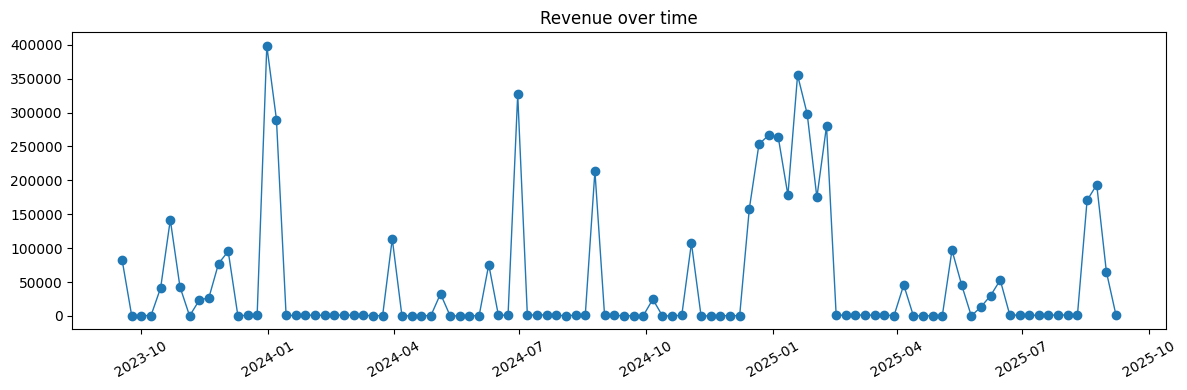

In [13]:
plt.figure(figsize=(12,4))
plt.plot(df['week'], df['revenue'], marker='o', linewidth=1)
plt.title('Revenue over time')
plt.xticks(rotation=30)
plt.tight_layout()

## Preprocessing & Feature Engineering

In [14]:
EPS = 1e-6
for col in ['revenue', 'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']:
    df[f'ln_{col}'] = np.log(df[col] + EPS)

In [15]:
def adstock(series, rate=0.5):
    result = np.zeros(len(series))
    prev = 0.0
    for i, x in enumerate(series):
        prev = x + rate * prev
        result[i] = prev
    return result

In [16]:
socials = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend','google_spend']

LAGS = [1,2,3] # Lag of 1-3 weeks

for lag in LAGS:
    for s in socials:
        df[f'{s}_lag{lag}'] = df[s].shift(lag)

In [17]:
fwy = df['week'].dt.isocalendar().week.astype(int)
df['week_of_year'] = fwy
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

if df['promotions'].dtype == 'object':
    df['promotions_bin'] = (df['promotions'].str.lower().isin(['yes','true','1'])).astype(int)
else:
    df['promotions_bin'] = df['promotions']

In [18]:
mean_price = df['average_price'].mean()
df['price_dev'] = df['average_price'] - mean_price

for c in ['emails_send','sms_send']:
    df[c] = df[c].fillna(0)

df = df.dropna().reset_index(drop=True)
print('After lag dropna shape:', df.shape)

After lag dropna shape: (101, 38)


## Tuning for Adstock

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [20]:
rates_grid = np.arange(0.1, 0.9, 0.1)
best_rates = {}

TARGET = 'ln_revenue'

for ch in socials:
    best_score = np.inf
    best_r = 0.5
    for r in rates_grid:
        tmp = df.copy()
        tmp[f'{ch}_adstock'] = adstock(tmp[ch].fillna(0).values, rate=r)

        tmp[f'ln_{ch}_adstock'] = np.log(tmp[f'{ch}_adstock'] + EPS)

        for s in socials:
            if s == ch:
                continue

            tmp[f'{s}_adstock'] = adstock(tmp[s].fillna(0).values, rate=0.5)
            tmp[f'ln_{s}_adstock'] = np.log(tmp[f'{s}_adstock'] + EPS)

        feats = ['ln_facebook_spend_adstock','ln_tiktok_spend_adstock','ln_instagram_spend_adstock','ln_snapchat_spend_adstock',
                 'ln_google_spend_adstock','social_followers','price_dev','promotions_bin','emails_send','sms_send','week_sin','week_cos']

        feats = [c for c in feats if c in tmp.columns]
        X = tmp[feats]
        y = tmp[TARGET]


        tscv = TimeSeriesSplit(n_splits=4)
        rmses = []

        for train_idx, test_idx in tscv.split(X):
            Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
            ytr, yte = y.iloc[train_idx], y.iloc[test_idx]
            scaler = StandardScaler()
            Xtr_s = scaler.fit_transform(Xtr)
            Xte_s = scaler.transform(Xte)
            model = Ridge(alpha=10.0)
            model.fit(Xtr_s, ytr)
            pred = model.predict(Xte_s)
            rmses.append(rmse(yte, pred))

        mean_rmse = np.mean(rmses)

        if mean_rmse < best_score:
            best_score = mean_rmse
            best_r = r

    best_rates[ch] = best_r
    print(f'Best adstock rate for {ch}: {best_r} (CV rmse ln: {best_score:.3f})')

Best adstock rate for facebook_spend: 0.8 (CV rmse ln: 3.263)
Best adstock rate for tiktok_spend: 0.8 (CV rmse ln: 3.407)
Best adstock rate for instagram_spend: 0.1 (CV rmse ln: 3.381)
Best adstock rate for snapchat_spend: 0.8 (CV rmse ln: 3.394)
Best adstock rate for google_spend: 0.8 (CV rmse ln: 3.413)


In [21]:
for s in socials:
    r = best_rates.get(s, 0.5)
    df[f'{s}_adstock'] = adstock(df[s].fillna(0).values, rate=r)
    df[f'ln_{s}_adstock'] = np.log(df[f'{s}_adstock'] + EPS)

## Two Stage Mediation

In [22]:
SOCIAL_FEATS = ['ln_facebook_spend','ln_tiktok_spend','ln_instagram_spend','ln_snapchat_spend']
MEDIATOR = 'ln_google_spend'
OTHER_FEATS = ['ln_facebook_spend_adstock','ln_tiktok_spend_adstock','ln_instagram_spend_adstock','ln_snapchat_spend_adstock',
               'ln_google_spend_adstock', 'social_followers','price_dev','promotions_bin','emails_send','sms_send','week_sin','week_cos']

X_stage1 = df[SOCIAL_FEATS]
y_stage1 = df[MEDIATOR]

grid1 = GridSearchCV(Ridge(), {'alpha':[0.1,1.0,10.0]}, cv=TimeSeriesSplit(n_splits=4), scoring='neg_mean_squared_error')
grid1.fit(X_stage1, y_stage1)

stage1_model = grid1.best_estimator_

print('Stage1 best alpha:', grid1.best_params_)
df['pred_ln_google'] = stage1_model.predict(X_stage1)

Stage1 best alpha: {'alpha': 10.0}


## XGB Model

In [23]:
STRICT_FEATURES_STAGE2 = ['pred_ln_google', 'ln_google_spend_adstock', 'social_followers','price_dev','promotions_bin','emails_send','sms_send','week_sin','week_cos']

X_stage2 = df[STRICT_FEATURES_STAGE2]
y_stage2 = df[TARGET]

scaler = StandardScaler()
X_stage2_scaled = scaler.fit_transform(X_stage2)

param_grid = {'alpha':[0.01,0.1,1.0,10.0,100.0]}
cv = TimeSeriesSplit(n_splits=4)
rg = GridSearchCV(Ridge(), param_grid, cv=cv, scoring='neg_mean_squared_error')
rg.fit(X_stage2_scaled, y_stage2)
print('Ridge best alpha:', rg.best_params_)
best_ridge = rg.best_estimator_

xgb = XGBRegressor(random_state=SEED, objective='reg:squarederror', verbosity=0)
xgb_params = {'n_estimators':[50,200], 'max_depth':[3,6], 'learning_rate':[0.05,0.2]}

xgb_grid = GridSearchCV(xgb, xgb_params, cv=cv, scoring='neg_mean_squared_error')
xgb_grid.fit(X_stage2, y_stage2)
print('XGB best params:', xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_

Ridge best alpha: {'alpha': 1.0}
XGB best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [25]:
lgbm = lgb.LGBMRegressor(random_state=SEED, verbosity=-1)
lgb_params = {'n_estimators':[50,200], 'num_leaves':[31,127], 'learning_rate':[0.05,0.2]}
lgb_grid = GridSearchCV(lgbm, lgb_params, cv=cv, scoring='neg_mean_squared_error')
lgb_grid.fit(X_stage2, y_stage2)
print('LGB best params:', lgb_grid.best_params_)
best_lgb = lgb_grid.best_estimator_

LGB best params: {'learning_rate': 0.2, 'n_estimators': 50, 'num_leaves': 31}


## Evals

In [26]:
metrics = []
min_train = int(0.5 * len(df))

for split_point in range(min_train, len(df) - 8, 4):
    train_idx = list(range(split_point))
    test_idx = list(range(split_point, min(split_point+8, len(df))))

    s1 = clone(stage1_model)
    s1.fit(X_stage1.iloc[train_idx], y_stage1.iloc[train_idx])
    pred_g_test = s1.predict(X_stage1.iloc[test_idx])

    Xtr = X_stage2.iloc[train_idx].copy()
    Xte = X_stage2.iloc[test_idx].copy()
    Xtr['pred_ln_google'] = s1.predict(X_stage1.iloc[train_idx])
    Xte['pred_ln_google'] = pred_g_test

    sc = StandardScaler()
    Xtr_s = sc.fit_transform(Xtr)
    Xte_s = sc.transform(Xte)
    r = Ridge(alpha=best_ridge.alpha)
    r.fit(Xtr_s, y_stage2.iloc[train_idx])
    pr = r.predict(Xte_s)

    xb = clone(best_xgb)
    xb.fit(Xtr, y_stage2.iloc[train_idx])
    px = xb.predict(Xte)

    lb = clone(best_lgb)
    lb.fit(Xtr, y_stage2.iloc[train_idx])
    pl = lb.predict(Xte)

    metrics.append({'split_start': split_point,
                    'rmse_ln_ridge': rmse(y_stage2.iloc[test_idx], pr),
                    'rmse_ln_xgb': rmse(y_stage2.iloc[test_idx], px),
                    'rmse_ln_lgb': rmse(y_stage2.iloc[test_idx], pl)})

In [27]:
met_df = pd.DataFrame(metrics)
print(met_df.describe())

       split_start  rmse_ln_ridge  rmse_ln_xgb  rmse_ln_lgb
count    11.000000      11.000000    11.000000    11.000000
mean     70.000000       3.511303     2.731802     3.630221
std      13.266499       1.341757     0.847671     1.397130
min      50.000000       1.870860     1.309761     1.418193
25%      60.000000       2.293240     2.242106     2.433987
50%      70.000000       3.540084     2.670869     3.709455
75%      80.000000       4.404901     3.297228     4.826666
max      90.000000       5.985408     4.066664     5.320533


In [28]:
mean_ridge = met_df['rmse_ln_ridge'].mean()
mean_xgb = met_df['rmse_ln_xgb'].mean()
mean_lgb = met_df['rmse_ln_lgb'].dropna().mean() if best_lgb else np.inf
print('Mean RMSE ln - Ridge:', mean_ridge, 'XGB:', mean_xgb, 'LGB:', mean_lgb)

full_s1 = clone(stage1_model).fit(X_stage1, y_stage1)
X_full = X_stage2.copy()
X_full['pred_ln_google'] = full_s1.predict(X_stage1)

best_xgb.fit(X_full, y_stage2)

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_full)

mean_abs_shap = pd.DataFrame({'feature':X_full.columns, 'mean_abs_shap':np.abs(shap_values.values).mean(axis=0)})
print(mean_abs_shap.sort_values('mean_abs_shap', ascending=False))

pred_full = best_xgb.predict(X_full)
resid = y_stage2 - pred_full
print('Residuals mean:', resid.mean(), 'std:', resid.std())

Mean RMSE ln - Ridge: 3.5113025755630662 XGB: 2.7318018136895765 LGB: 3.630220591276523
                   feature  mean_abs_shap
0           pred_ln_google       1.320589
3                price_dev       1.070358
6                 sms_send       0.175262
8                 week_cos       0.156810
2         social_followers       0.096918
1  ln_google_spend_adstock       0.065986
4           promotions_bin       0.051478
7                 week_sin       0.008280
5              emails_send       0.000000
Residuals mean: 0.0002398442708596648 std: 1.3188143351279784


Text(0.5, 1.0, 'Residuals over time')

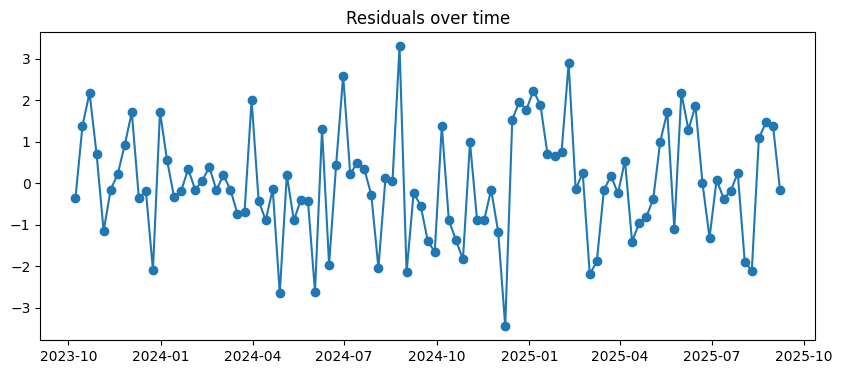

In [31]:
plt.figure(figsize=(10,4))
plt.plot(df['week'].iloc[-len(resid):], resid, marker='o')
plt.title('Residuals over time')

In [32]:
resid

,ln_revenue
0,-0.359743
1,1.386509
2,2.175957
3,0.702609
4,-1.150389
...,...
96,-2.106787
97,1.080014
98,1.464431
99,1.389581


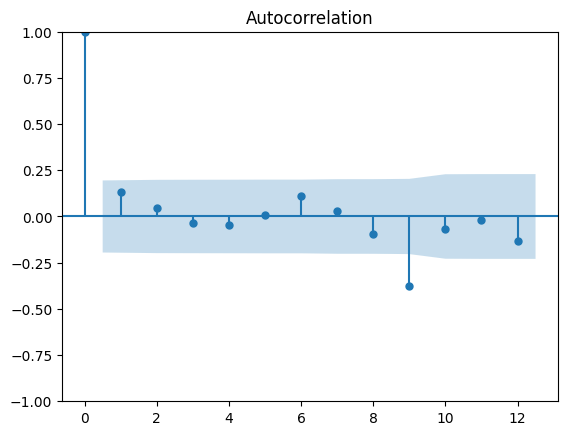

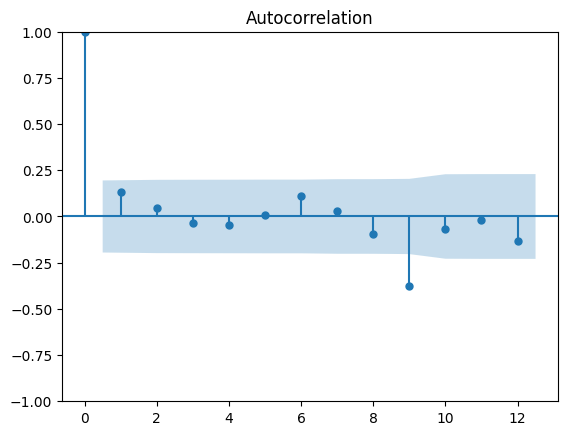

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(resid, lags=12)

In [34]:
import joblib
joblib.dump(full_s1, 'stage1_model_tuned.pkl')
joblib.dump(best_xgb, 'stage2_xgb_model.pkl')
joblib.dump(rg.best_estimator_, 'stage2_ridge_model.pkl')

['stage2_ridge_model.pkl']